
# Tensorboard setup

Go to the link generated by the code to look at the training loss curve, you can add accuracy and other things to the plot. Refer to the recitation 2 code for referance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/ESE_546_HW2'

/content/drive/MyDrive/ESE_546_HW2


In [3]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi


Ngrok already installed


In [4]:
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

In [5]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

  

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

logger = Logger('./logs')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

# Training Loop on CIFAR 10.


 The model currently does not achieve less than 12% validation error, you have to tweak the parameters to get it.

4) a)

In [7]:
import os
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_aug = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_aug)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

def get_loss_and_error(loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_sum = 0
        count = 0
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            count += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss_sum / count, 100 * (total - correct) / total
    # print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# The training loop
tl = []
te = []
vl = []
ve = []

def train(net, optimizer, scheduler, criterion, train_loader, test_loader, epochs, model_name, plot):
    model = net.to(device)
    total_step = len(train_loader)
    train_loss_step = 0
    train_error_step = 0
    val_loss_step = 0
    val_error_step = 0
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0
        train_count = 0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_count += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        path = os.path.join('/content/drive/MyDrive/ESE_546_HW2/',str(epoch))
        torch.save({
              'epoch': epoch,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, path)
        model.eval()
        with torch.no_grad():
          correct = 0
          total = 0
          loss_sum = 0
          count = 0
          for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            count += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("__________" + str(epoch) + "__________")
        print('Train loss: ' + str(train_loss / train_count))
        print('Val loss: ' + str(loss_sum / count))
        print('Accuracy of the network on the train images: {} %'.format(100 * train_correct / train_total))
        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        print("_______________________")
        tl.append(train_loss / train_count)
        te.append(100 - (100 * train_correct / train_total))
        vl.append(loss_sum / count)
        ve.append(100 - (100 * correct / total))
        if plot:
            info = { ('train_loss_' + model_name): (train_loss / train_count) }
            for tag, value in info.items():
                logger.scalar_summary(tag, value, train_loss_step+1)
                train_loss_step +=1
            info = { ('train_error_' + model_name): (100 - (100 * train_correct / train_total)) }
            for tag, value in info.items():
                logger.scalar_summary(tag, value, train_error_step+1)
                train_error_step +=1
            info = { ('val_loss_' + model_name): (loss_sum / count) }
            for tag, value in info.items():
                logger.scalar_summary(tag, value, val_loss_step+1)
                val_loss_step +=1
            info = { ('val_error_' + model_name): (100 - (100 * correct / total)) }
            for tag, value in info.items():
                logger.scalar_summary(tag, value, val_error_step+1)
                val_error_step +=1
        scheduler.step(100 - (100 * train_correct / train_total))
        if (100 * total - correct / total) < 12:
            break

model = allcnn_t().to(device)
#TODO: Set it as number of epochs states in the question
epochs = 50
# TODO: Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# TODO: Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, threshold=0.01, cooldown=5, verbose=True)
# Training loop called here
train(model, optimizer, scheduler, criterion, trainloader, testloader, epochs, 'cnn', True)

Num parameters:  1667166
__________0__________
Train loss: 1.7666353156280517
Val loss: 1.6217308933258057
Accuracy of the network on the train images: 34.054 %
Accuracy of the network on the test images: 39.13 %
_______________________
__________1__________
Train loss: 1.579665013370514
Val loss: 1.5268107672691345
Accuracy of the network on the train images: 42.534 %
Accuracy of the network on the test images: 46.25 %
_______________________
__________2__________
Train loss: 1.5340294222831725
Val loss: 1.5741477224349976
Accuracy of the network on the train images: 44.334 %
Accuracy of the network on the test images: 46.11 %
_______________________
__________3__________
Train loss: 1.5035178879356383
Val loss: 1.558163412952423
Accuracy of the network on the train images: 45.97 %
Accuracy of the network on the test images: 44.68 %
_______________________
__________4__________
Train loss: 1.4848533400154114
Val loss: 1.4915010313034058
Accuracy of the network on the train images: 46.

In [ ]:
def additional_train(net, optimizer, scheduler, criterion, train_loader, test_loader, start, end, init_lr, model_name, plot):
    total_step = len(train_loader)
    train_loss_step = 0
    train_error_step = 0
    val_loss_step = 0
    val_error_step = 0
    for g in optimizer.param_groups:
        g['lr'] = init_lr
    for epoch in range(start, end):
        model.train()
        if epoch % 5 == 0 and epoch > 0:
          for g in optimizer.param_groups:
            g['lr'] /= 2
        train_correct = 0
        train_total = 0
        train_loss = 0
        train_count = 0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            train_count += 1
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        path = os.path.join('/content/drive/MyDrive/ESE_546_HW2/',str(epoch))
        torch.save({
              'epoch': epoch,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()
              }, path)
        model.eval()
        with torch.no_grad():
          correct = 0
          total = 0
          loss_sum = 0
          count = 0
          for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            count += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("__________" + str(epoch) + "__________")
        print('Train loss: ' + str(train_loss / train_count))
        print('Val loss: ' + str(loss_sum / count))
        print('Accuracy of the network on the train images: {} %'.format(100 * train_correct / train_total))
        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        print("_______________________")
        tl.append(train_loss / train_count)
        te.append(100 - (100 * train_correct / train_total))
        vl.append(loss_sum / count)
        ve.append(100 - (100 * correct / total))
        if plot:
            info = { ('train_loss_' + model_name): (train_loss / train_count) }
            for tag, value in info.items():
                logger.scalar_summary(tag, value, train_loss_step+1)
                train_loss_step +=1
            info = { ('train_error_' + model_name): (100 - (100 * train_correct / train_total)) }
            for tag, value in info.items():
                logger.scalar_summary(tag, value, train_error_step+1)
                train_error_step +=1
            info = { ('val_loss_' + model_name): (loss_sum / count) }
            for tag, value in info.items():
                logger.scalar_summary(tag, value, val_loss_step+1)
                val_loss_step +=1
            info = { ('val_error_' + model_name): (100 - (100 * correct / total)) }
            for tag, value in info.items():
                logger.scalar_summary(tag, value, val_error_step+1)
                val_error_step +=1
        if (100 * total - correct / total) < 12:
            break

# Training loop called here
additional_train(model, optimizer, scheduler, criterion, trainloader, testloader, 50, 80, 0.001, 'cnn', True)

__________50__________
Train loss: 0.5991313301181793
Val loss: 0.4566460668683052
Accuracy of the network on the train images: 80.596 %
Accuracy of the network on the test images: 85.0 %
_______________________
__________51__________
Train loss: 0.540267585709095
Val loss: 0.44704690083861354
Accuracy of the network on the train images: 82.538 %
Accuracy of the network on the test images: 85.37 %
_______________________
__________52__________
Train loss: 0.5221022888541221
Val loss: 0.4542666247189045
Accuracy of the network on the train images: 83.19 %
Accuracy of the network on the test images: 84.82 %
_______________________
__________53__________
Train loss: 0.5010116364049911
Val loss: 0.425508891159296
Accuracy of the network on the train images: 83.88 %
Accuracy of the network on the test images: 85.96 %
_______________________
__________54__________
Train loss: 0.4860381266760826
Val loss: 0.4094580923140049
Accuracy of the network on the train images: 84.376 %
Accuracy of the

In [ ]:
additional_train(model, optimizer, scheduler, criterion, trainloader, testloader, 80, 100, 1.5625e-05, 'cnn', True)

__________80__________
Train loss: 0.4162024236261845
Val loss: 0.3939291350156069
Accuracy of the network on the train images: 86.736 %
Accuracy of the network on the test images: 86.94 %
_______________________
__________81__________
Train loss: 0.4107598439180851
Val loss: 0.38905442000627516
Accuracy of the network on the train images: 86.898 %
Accuracy of the network on the test images: 86.95 %
_______________________
__________82__________
Train loss: 0.4150199200892448
Val loss: 0.3741983349323273
Accuracy of the network on the train images: 86.888 %
Accuracy of the network on the test images: 87.66 %
_______________________
__________83__________
Train loss: 0.4164391869521141
Val loss: 0.3886598583519459
Accuracy of the network on the train images: 86.682 %
Accuracy of the network on the test images: 87.01 %
_______________________
__________84__________
Train loss: 0.41341097297906876
Val loss: 0.3818434391260147
Accuracy of the network on the train images: 86.846 %
Accuracy 

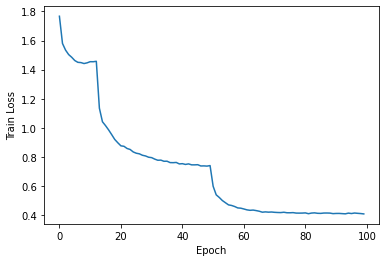

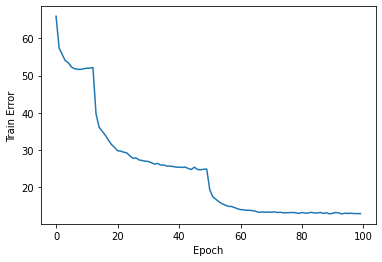

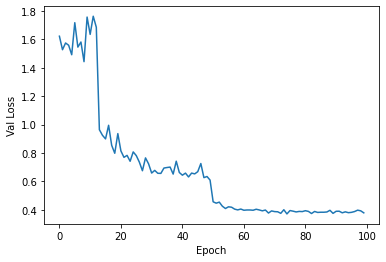

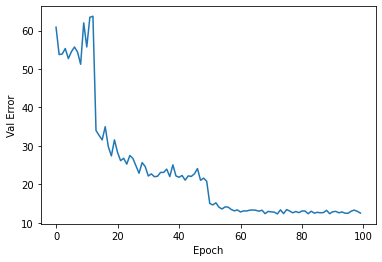

In [ ]:
import matplotlib.pyplot as plt
epochs = list(range(len(tl)))
plt.figure()
plt.plot(epochs, tl)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.savefig("Train_Loss"+".png")
plt.show()

plt.figure()
plt.plot(epochs, te)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.savefig("Train_Error"+".png")
plt.show()

plt.figure()
plt.plot(epochs, vl)
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.savefig("Val_Loss"+".png")
plt.show()

plt.figure()
plt.plot(epochs, ve)
plt.xlabel("Epoch")
plt.ylabel("Val Error")
plt.savefig("Val_Error"+".png")
plt.show()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir logs

4) b)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = allcnn_t().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

assignment_path = '/content/drive/MyDrive/ESE_546_HW2/best'
checkpoint = torch.load(assignment_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

print(get_loss_and_error(testloader))

Num parameters:  1667166
(0.3754799329340458, 12.29)


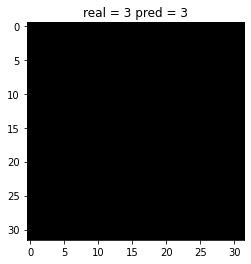

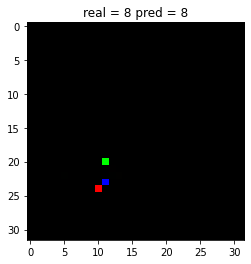

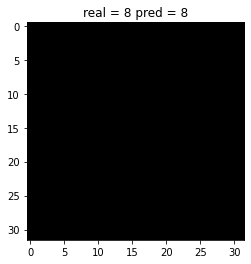

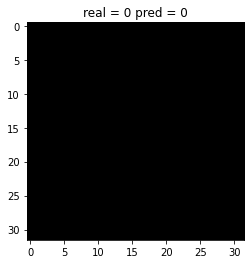

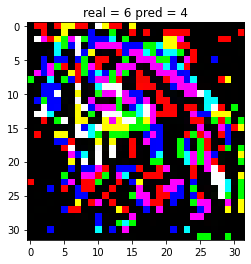

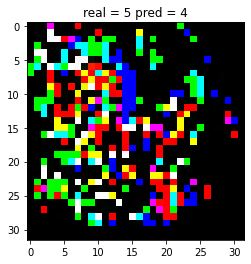

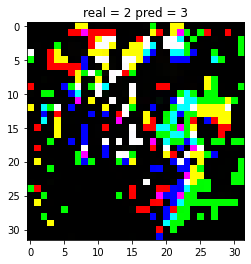

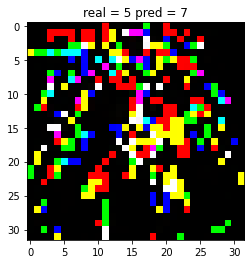

In [10]:
import matplotlib.pyplot as plt
def get_classification_examples(loader):
    model.eval()
    count = 0
    correct_images = []
    correct_grads = []
    correct_preds = []
    correct_gts = []
    wrong_images = []
    wrong_grads = []
    wrong_preds = []
    wrong_gts = []
    for i, (images, labels) in enumerate(loader):
        if count > 4:
            break
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad_()
        yh = model.forward(images)
        loss = nn.CrossEntropyLoss()
        loss = loss.forward(yh, labels)
        loss.backward()
        gradients = images.grad.data.clone()
        _, predicted = torch.max(yh.data, 1)
        optimizer.zero_grad()
        correct = torch.where(predicted == labels)[0]
        wrong = torch.where(predicted != labels)[0]
        for j in range(correct.shape[0]):
            correct_images.append(images[correct[j]])
            correct_grads.append(gradients[correct[j]])
            correct_preds.append(predicted[correct[j]].item())
            correct_gts.append(labels[correct[j]].item())
        for j in range(wrong.shape[0]):
            wrong_images.append(images[wrong[j]])
            wrong_grads.append(gradients[wrong[j]])
            wrong_preds.append(predicted[wrong[j]].item())
            wrong_gts.append(labels[wrong[j]].item())
        count += list(wrong.shape)[0]
    return correct_images, correct_grads, correct_preds, correct_gts, wrong_images, wrong_grads, wrong_preds, wrong_gts

c_in, c, cp, cl, w_in, w, wp, wl = get_classification_examples(testloader)
for i in range(4):
    plt.figure()
    img = np.squeeze(c[i]).cpu().detach().numpy()
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    plt.imshow((img*255).astype(np.uint8))
    plt.title("real = " + str(cl[i]) + " pred = " + str(cp[i]))
for i in range(4):
    plt.figure()
    img = np.squeeze(w[i]).cpu().detach().numpy()
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)
    plt.imshow((img*255).astype(np.uint8))
    plt.title("real = " + str(wl[i]) + " pred = " + str(wp[i]))

The images which are correctly classified have few if none non-zero gradients but the incorrectly classified images have quite many non-zero gradients which likely caused the incorrect predictions.

Files already downloaded and verified


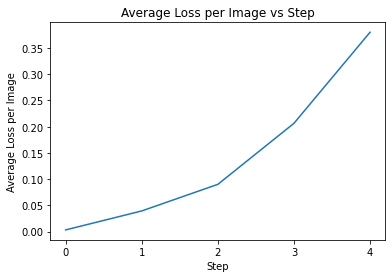

In [11]:
import matplotlib.pyplot as plt

eps = 8
newtestset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
newtestloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False)

def get_perturbed_losses(loader):
    model.eval()
    losses = []
    for i, (images, labels) in enumerate(loader):
        if i > 0:
            break
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad_()
        for k in range(5):
            yh = model.forward(images)
            loss = nn.CrossEntropyLoss()
            loss = loss.forward(yh, labels)
            loss.backward(retain_graph=True)
            gradients = images.grad.data.clone()
            if gradients.is_leaf: 
                gradients.requires_grad = True
            images = images + eps*torch.sign(gradients)
            images.retain_grad()
            losses.append(loss.item() / 100)
            optimizer.zero_grad()
        return losses

losses = get_perturbed_losses(newtestloader)
plt.figure()
plt.plot(list(range(5)), losses)
plt.xlabel("Step")
plt.xticks([0,1,2,3,4])
plt.ylabel("Average Loss per Image")
plt.title("Average Loss per Image vs Step")
plt.savefig("avg_loss_perturbed"+".png")
plt.show()

4) c)

In [15]:
def get_accuracy(loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_sum = 0
        count = 0
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_sum += loss.item()
            count += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def get_accuracy_perturbed(loader, eps):
    model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        images.requires_grad_()
        for k in range(1):
            yh = model.forward(images)
            loss = nn.CrossEntropyLoss()
            loss = loss.forward(yh, labels)
            loss.backward(retain_graph=True)
            gradients = images.grad.data.clone()
            if gradients.is_leaf: 
                gradients.requires_grad = True
            images = images + eps*torch.sign(gradients)
            images.retain_grad()
            losses.append(loss.item() / 100)
            optimizer.zero_grad()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

print('Unperturbed validation dataset accuracy: ' + str(get_accuracy(testloader)) + '%')
print('Perturbed validation dataset accuracy: ' + str(get_accuracy_perturbed(testloader, 8)) + '%')

Unperturbed validation dataset accuracy: 87.71%
Perturbed validation dataset accuracy: 12.68%


The accuracy on the perturbed dataset is 12.68%, as opposed to the original unperturbed dataset's 87.71%. This result shows that even a single step is sufficient to severely reduce the predictive power of the network.